In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
try:
    import ipyplot
except:
    !pip install ipyplot
from ipyplot import plot_images
from plotly import express as ex

In [17]:
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.models import SimilarityModel
from tensorflow_similarity.losses import PNLoss, TripletLoss

In [114]:
fname = '../tmp/quickdraw/full_numpy_bitmap_flamingo.npy'
x = np.load(fname)

In [115]:
len(x)

124569

In [30]:
augment_layers = tf.keras.Sequential([
  layers.Rescaling(scale=1./255), # rescale between [0, 1]
  layers.Reshape((28, 28, 1)),  # put back the image in 2D
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='constant'),
])

# augmenter
the augmenter `num_augmentation` is indeed the value passed 
as SingleShotMemorySampler(num_augmentation)

In [99]:

def augmenter(x, y, num_augmentation: int, is_warmup: bool):

    # double Y  as we have normal + aug
    rep_y = tf.constant([num_augmentation], tf.int32)  # shape (128,)
    aug_y = tf.tile(tf.constant(y), rep_y)
    
    rep_x = tf.constant([num_augmentation, 1], tf.int32)  # shape (128, 768)
    aug_x = tf.tile(tf.constant(x), rep_x)
    # x2 = tf.concat([x, x], axis=0)
    # x2 = tf.random.shuffle(x2)
    # reshape and augment
    aug_x = augment_layers(aug_x)
    
    # merge aug and x
    # aug_x = tf.concat([x, aug_x], axis=0)
    return aug_x, aug_y

examples_per_batch = 32
num_augmentation_per_example = 2
sampler = SingleShotMemorySampler(x, augmenter, examples_per_batch=examples_per_batch, num_augmentations_per_example=num_augmentation_per_example)




Batch size is 64 -> 32 class X 2 examples


generate a batch used to check to vizualize the data and use as valdiation data to track progress

Aug 1



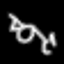
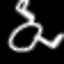
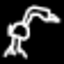
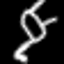
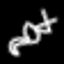
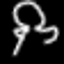
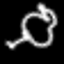
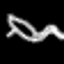
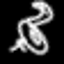
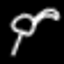
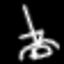
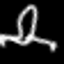


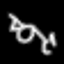
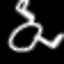
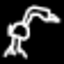
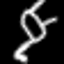
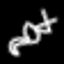
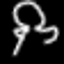
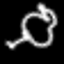
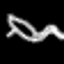
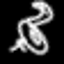
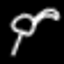
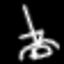
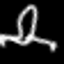

aug 2



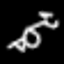
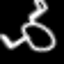
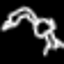
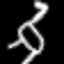
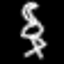
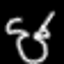
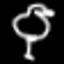
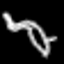
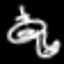
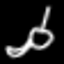
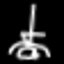
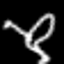


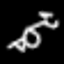
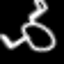
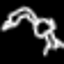
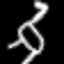
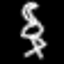
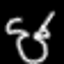
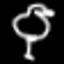
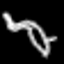
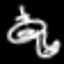
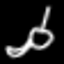
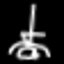
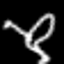

In [100]:

batch_x, batch_y = sampler.generate_batch(42)
p = tf.squeeze(batch_x, axis=-1)  # display requires to remove final dim
print("Aug 1")
plot_images(p, batch_y, max_images=12, img_width=64)
print("aug 2")
plot_images(p[examples_per_batch:], batch_y[examples_per_batch:], max_images=12, img_width=64)

In [131]:
def get_model():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, 3, activation='relu')(inputs)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation='relu')(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = MetricEmbedding(128)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_16 (Flatten)         (None, 4096)      

In [132]:
distance = 'cosine' #@param ["cosine", "L2", "L1"]{allow-input: false}
loss = PNLoss(distance=distance)

In [133]:
LR = 0.0001  #@param {type:"number"}
model = get_model()
model.compile(optimizer=Adam(LR), loss=loss)

Distance metric automatically set to cosine use the distance arg to override.


In [134]:
EPOCHS = 10 #@param {type:"integer"}
history = model.fit(sampler, epochs=EPOCHS, validation_data=(batch_x, batch_y))

Epoch 1/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.8853 - val_loss: 0.6636
Epoch 2/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.7464 - val_loss: 0.6171
Epoch 3/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.6808 - val_loss: 0.5682
Epoch 4/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.6337 - val_loss: 0.5494
Epoch 5/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.6028 - val_loss: 0.5348
Epoch 6/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.5818 - val_loss: 0.5187
Epoch 7/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.5585 - val_loss: 0.5126
Epoch 8/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.5385 - val_loss: 0.4793
Epoch 9/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.5175 - val_loss: 0.4796
Epoch 10/10
1000/1000 [==============================] - 20s 20m

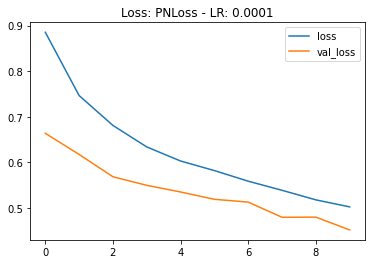

In [135]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(f'Loss: {loss.name} - LR: {LR}')
plt.show()

In [137]:
num_batches = 100
model.reset_index()  # reset index
for i in tqdm(range(num_batches), 'indexing'):
    ix, iy = sampler.generate_batch(i)
    model.index(ix, iy, verbose=0)
print("Index size", model.index_size())

indexing: 100%|██████████| 100/100 [00:11<00:00,  8.79it/s]

Index size 6400


In [138]:
test_batches = 30
distances = []
for i in tqdm(range(test_batches)):
    ix, iy = sampler.generate_batch(i)
    nns = model.lookup(ix, verbose=0)
    distances.extend([n[0].distance for n in nns])
avg_distance = np.average(distances)
std_distance = np.std(distances)
cutpoint = avg_distance + 3 * std_distance  # find the 1% of weird example 
print(avg_distance, std_distance, cutpoint)


100%|██████████| 30/30 [00:01<00:00, 16.24it/s]

0.1799730356472234 0.07097110968884522 0.39288636471375904


In [139]:
ex.histogram(x=distances, title="distances to index")

In [140]:
examples_to_check = len(x)
batch_size = 128  # its faster to do a bulk lookup
res_x  = np.reshape(x[:examples_to_check] / 255, (examples_to_check, 28, 28, 1))
pb = tqdm(total=examples_to_check)
anomalies = []
for i in range(0, examples_to_check - batch_size, batch_size):
    batch = res_x[i: i + batch_size]  # batch
    nns = model.lookup(batch, verbose=0)
    for idx in range(batch_size):
        example = res_x[i + idx]
        distance = nns[idx][0].distance
        if  distance> cutpoint:
            # store the image
            anomalies.append([distance, np.squeeze(example, axis=-1), example])
            pb.set_postfix({"anomalies": len(anomalies)})
        pb.update()
pb.close()

100%|█████████▉| 124544/124569 [00:36<00:00, 3389.37it/s, anomalies=158]


In [141]:
anomalies = sorted(anomalies, key=lambda x: x[0], reverse=True)
imgs = [a[1] for a in anomalies]
dist = [round(a[0], 2) for a in anomalies]
ids = [a[2] for a in anomalies]


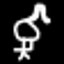
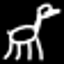
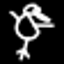
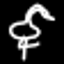
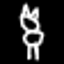
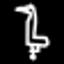
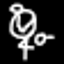
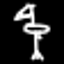
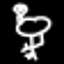
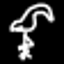
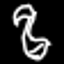
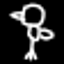
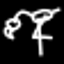
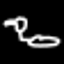
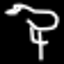
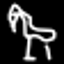
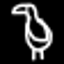
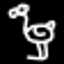
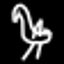
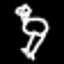
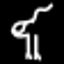
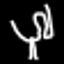
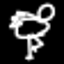
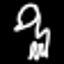
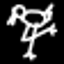
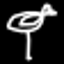
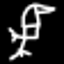
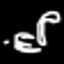
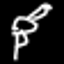
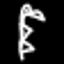
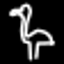
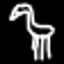
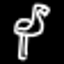
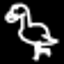
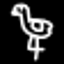
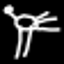
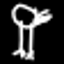
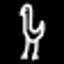
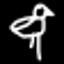
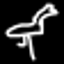
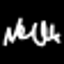
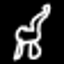
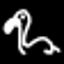
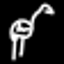
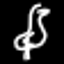
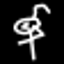
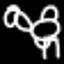
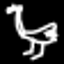
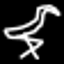
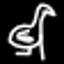
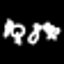
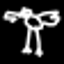
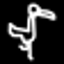
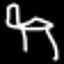
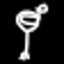
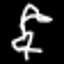
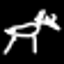
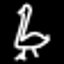
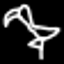
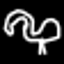
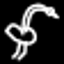
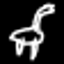
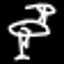
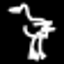


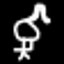
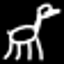
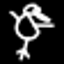
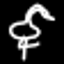
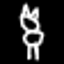
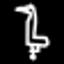
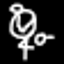
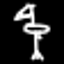
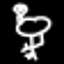
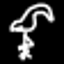
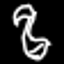
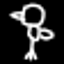
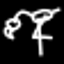
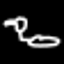
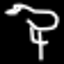
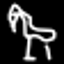
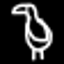
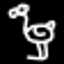
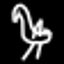
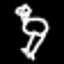
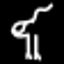
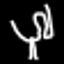
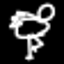
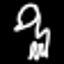
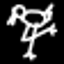
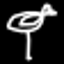
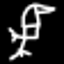
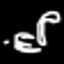
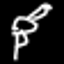
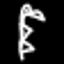
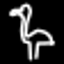
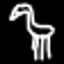
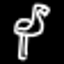
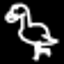
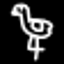
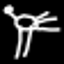
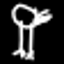
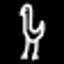
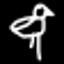
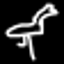
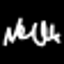
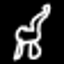
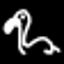
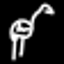
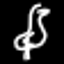
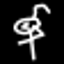
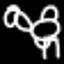
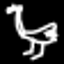
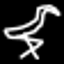
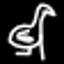
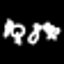
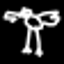
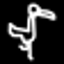
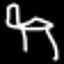
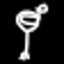
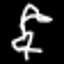
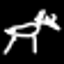
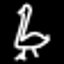
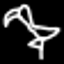
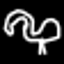
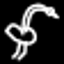
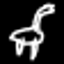
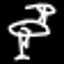
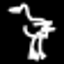

In [142]:
plot_images(imgs, dist, max_images=64, img_width=64)